In this notebook we take the Illustris-1 simulation volume to find Local Group candidates.

Usually these candidates are found using the dark matter information. 
In this notebook we take a different approach by selecting them based on the baryonic information.

Our candidates are thus pairs selected based on the stellar masses.

1. They are composed by two dark galaxies $G_A$ and $G_B$.
2. $G_A$ and $G_B$ belong to the set of dark matter halos $S_{1}$; $S_{1}$ contains all subhalos with stellar mass content  $2.6\times 10^{10}$ M$_{\odot}<M_s < 1.2\times 10^{11}$ M$_{\odot}$ (http://adsabs.harvard.edu//abs/2013AAS...22125411L, http://arxiv.org/abs/1410.0017)
3. The distance between $H_A$ and $H_B$ is less than 1.3 Mpc.
4. The relative physical velocity (i.e. after taking into account the Hubble flow) is less than $150 \mathrm{km/s}$
5. $H_A$ and $H_B$ are mutually its nearest halos in the set $S_{1}$.
6. There are not any halos more massive than $5\times 10^{12} $ M$_{\odot}$ within $5 \mathrm{Mpc}$ of either $H_A$ or $H_B$.
7. There are not any halos more massive than $1\times 10^{14} $ M$_{\odot}$ within $12 \mathrm{Mpc}$ of either $H_A$ or $H_B$.

We now proceed to build such sample.

In [6]:
%pylab inline
import illustris_python as il
from sklearn.neighbors import NearestNeighbors

Populating the interactive namespace from numpy and matplotlib


In [7]:
basePath = '/homecolab/je.forero/data/illustris/illustris-1/'

In [8]:
halos = il.groupcat.loadHalos(basePath,135)
subhalos = il.groupcat.loadSubhalos(basePath,135)

In [45]:
header = il.groupcat.loadHeader(basePath,135)
hubble = 0.7
BoxSize = header['BoxSize']/hubble

In [46]:
print halos.keys()
print subhalos.keys()

[u'Group_M_Crit200', u'Group_R_Mean200', u'GroupMass', u'Group_M_Mean200', u'GroupStarMetallicity', u'GroupVel', u'GroupBHMass', u'GroupMassType', u'Group_R_Crit200', u'GroupFirstSub', u'GroupSFR', u'GroupPos', u'Group_M_TopHat200', u'Group_M_Crit500', u'GroupLenType', u'Group_R_Crit500', u'GroupNsubs', u'Group_R_TopHat200', u'GroupGasMetallicity', 'count', u'GroupBHMdot', u'GroupWindMass', u'GroupLen']
[u'SubhaloPos', u'SubhaloBHMdot', u'SubhaloVmax', u'SubhaloWindMass', u'SubhaloGasMetallicityMaxRad', u'SubhaloVelDisp', u'SubhaloSFR', u'SubhaloStarMetallicityMaxRad', u'SubhaloLen', u'SubhaloSFRinHalfRad', u'SubhaloStellarPhotometrics', u'SubhaloGasMetallicity', u'SubhaloBHMass', u'SubhaloIDMostbound', u'SubhaloMassType', u'SubhaloStellarPhotometricsMassInRad', u'SubhaloHalfmassRad', u'SubhaloParent', u'SubhaloSpin', u'SubhaloStarMetallicityHalfRad', u'SubhaloVel', u'SubhaloLenType', u'SubhaloGasMetallicitySfrWeighted', u'SubhaloGasMetallicityHalfRad', u'SubhaloMassInRad', u'SubhaloGr

In [47]:
#mases are: Gas, DM, unused, tracers, stars+wind particles, black holes
halo_masses = halos['GroupMassType']/hubble
subhalo_masses = subhalos['SubhaloMassType']/hubble
halo_M_crit200 = halos['Group_M_Mean200']/hubble
subhalo_stellar_mass = subhalo_masses[:,4]
subhalo_vmax = subhalos['SubhaloVmax']
print shape(subhalo_vmax)

(4366546,)


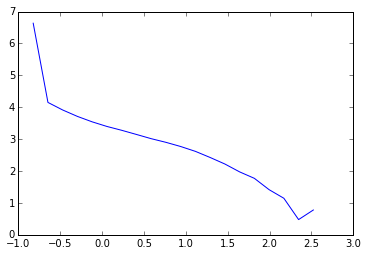

In [48]:
vals, edges = histogram(log10(subhalo_stellar_mass+1E-1), bins=20)
plot(edges[1:], log10(vals))

In [49]:
#selects the indices for two sets:
# 1. MW like
# 2. massive galaxies above 1E11 Msun in stars
# 3. MW like + massive galaxies above 1E11 Msun in stars

index_S1 = where((subhalo_stellar_mass>2.6) & (subhalo_stellar_mass<12.0))
index_S2 = where(subhalo_stellar_mass>12.0)
index_S3 = where(subhalo_stellar_mass>2.6)
n_S1 = size(index_S1)
n_S2 = size(index_S2)
n_S3 = size(index_S3)
print("size set S1: %d halos"%(n_S1))
print("size set S2: %d halos"%(n_S2))
print("size set S3: %d halos"%(n_S3))

size set S1: 2627 halos
size set S2: 696 halos
size set S3: 3323 halos


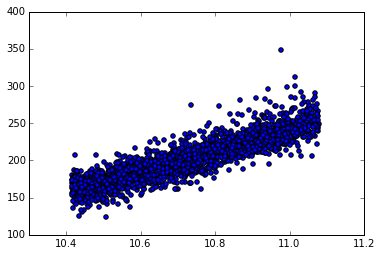

In [50]:
scatter(log10(subhalo_stellar_mass[index_S1])+10, subhalo_vmax[index_S1])

In [51]:
S3_pos = subhalos['SubhaloPos'][index_S3]/hubble
S3_vel = subhalos['SubhaloVel'][index_S3]
S3_vmax = subhalos['SubhaloVmax'][index_S3]/hubble
S3_stellar_mass = subhalo_stellar_mass[index_S3]
#https://github.com/forero/IllustrisLG/blob/master/code/LocalGroupSubVolumes.ipynb

In [54]:
#pad boxes around the S3 positions to mimic periodic boundary conditions
S3_pad_pos = S3_pos.copy()
S3_pad_vel = S3_vel.copy()
S3_pad_vmax = S3_vmax.copy()
S3_pad_stellar_mass = S3_stellar_mass.copy()
S3_pad_id = arange(n_S3)
for i in (0,1,-1):
    for j in (0,1,-1):
        for k in (0,1,-1):
            new_pos = S3_pos.copy()
            if(i):
                new_pos[:,0] = new_pos[:,0] + i*BoxSize
            if(j):
                new_pos[:,1] = new_pos[:,1] + j*BoxSize
            if(k):
                new_pos[:,2] = new_pos[:,2] + k*BoxSize
                
            if((i!=0) | (j!=0) | (k!=0)):
                S3_pad_pos = append(S3_pad_pos, new_pos, axis=0)
                S3_pad_vel = append(S3_pad_vel, S3_vel, axis=0)
                S3_pad_vmax = append(S3_pad_vmax, S3_vmax, axis=0)
                S3_pad_stellar_mass = append(S3_pad_stellar_mass, S3_stellar_mass, axis=0)
                S3_pad_ID = append(S3_pad_id, arange(n_S3))

In [55]:
nbrs_S3 = NearestNeighbors(n_neighbors=20, algorithm='ball_tree').fit(S3_pad_pos)
dist_S3, ind_S3 = nbrs_S3.kneighbors(S3_pad_pos)
print S3_pad_pos.shape
print dist_S3.shape

(89721, 3)
(89721, 20)


In [73]:
neighbor_index = ind_S3[:,1]
neighbor_list = ind_S3[:,2:]
print shape(neighbor_list)

n_pairs = 0

halo_A_id = empty((0), dtype=int)
halo_B_id = empty((0), dtype=int)

for i in range(n_S3):
    l = neighbor_index[neighbor_index[i]]% n_S3
    j = neighbor_index[i] % n_S3
    
    other_j = neighbor_list[i,:] % n_S3
    other_l = neighbor_list[neighbor_index[i],:] % n_S3
    
    if((i==l) & (not (j in halo_A_id)) & (not (j in halo_B_id))): # first check to find mutual neighbors
        
        if((S3_stellar_mass[i]<=12.0) & (S3_stellar_mass[j]<=12.0)): #second check on the masses of the two halos
            
            if(dist_S3[i,1]<(1300.0)): #third check on the distance between the two halos
  
                relative_vel = sqrt(sum((S3_pad_vel[i,:] - S3_pad_vel[j, :] + (hubble*100*dist_S3[i,1]/1000))**2))
                if(relative_vel<150.0): #check on the relative velocity
    
                    massive_close_to_i = any((dist_S3[i,2:]<(5000.0)) & (S3_stellar_mass[other_j]>=15.0))
                    massive_close_to_j = any((dist_S3[j,2:]<(5000.0)) & (S3_stellar_mass[other_l]>=15.0))
                    if((not massive_close_to_i) & (not massive_close_to_j)): #third check on isolation from massive halos
                
                        virgo_close_to_i = any((dist_S3[i,2:]<(12000.0)) & (S3_stellar_mass[other_j]>=100.0))
                        virgo_close_to_j = any((dist_S3[j,2:]<(12000.0)) & (S3_stellar_mass[other_l]>=100.0))
                        if((not virgo_close_to_i) & (not virgo_close_to_j)): # fourth check on virgo
                            n_pairs = n_pairs+ 1
                            halo_A_id = append(halo_A_id, int(i))
                            halo_B_id = append(halo_B_id, int(j))
print n_pairs

(89721, 18)
45


In [74]:
print dist_S3[halo_A_id,1]
print neighbor_index[halo_A_id]
print n_S3

[  175.74117759   324.3517516    324.02357642   272.19361071   238.27537882
   123.21734361   308.23720329   153.67968951   216.9621262    800.74458925
   835.42376272   619.12183612   171.22881941   243.28602601   814.65029198
  1090.11732669   452.21655336   702.98911791   837.23504401   492.0287007
   428.31422377   784.46197548   588.74239032   667.45261435  1196.16621112
   338.60058004   575.80691949  1075.79146077   539.2269212    864.57767144
   871.58135651   981.31046758  1294.98434281  1153.8239358   1297.8786667
   590.20520831  1210.78566652   628.86096251   848.85552343   852.56041487
   839.1503194    961.08123097  1190.97918174   959.94206121   875.65089592]
[ 1111  1114  1171  1277  1279  1304  1352  1355  1362  1364  1375  1389
  1428  1447  1467  1477  1481  1529  1551  1609  1666  1679  1683  1794
  2427  2130  3156  1703  2293  1674  2730  3194  1753  3026  2862  3288
  2610  3057 22118  3094  2698  2600  1839  3202  3277]
3323


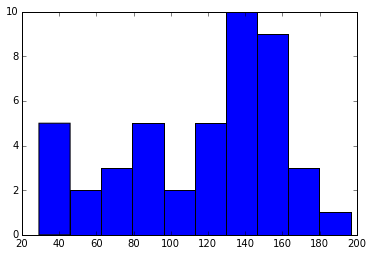

In [77]:
relative_vel = S3_pad_vel[halo_A_id,:] - S3_pad_vel[neighbor_index[halo_A_id], :]
norm_relative_vel = sqrt((relative_vel**2).sum(1))
a = hist(norm_relative_vel)

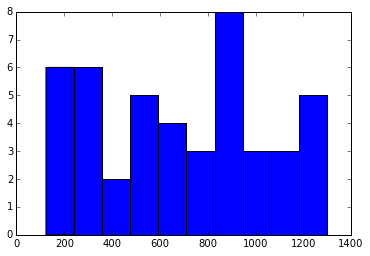

In [78]:
relative_pos = S3_pad_pos[halo_A_id,:] - S3_pad_pos[neighbor_index[halo_A_id], :]
norm_relative_pos = sqrt((relative_pos**2).sum(1))
a = hist(norm_relative_pos)

In [ ]:
relative_pos = S3_pad_pos[halo_A_id,:] - S3_pad_pos[neighbor_index[halo_A_id], :]
norm_relative_pos = sqrt((relative_pos**2).sum(1))